In [104]:
#Importing the library
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading the data
df = pd.read_csv('spam.csv')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
# drop last 3 column
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
# renaming the column to make more readable
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
encoder  = LabelEncoder()

In [9]:
df['target'] = encoder.fit_transform(df['target'])

In [10]:
df.head(3)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [11]:
#missing value 
df.isnull().sum()

target    0
text      0
dtype: int64

Their is good that we have no missing values

In [12]:
#Check for duplicate value
df.duplicated().sum()

403

In [13]:
#remove duplicate value
df = df.drop_duplicates(keep='first')

In [14]:
df.duplicated().sum()

0

In [15]:
# after deleting duplicate value check shape of the data
df.shape

(5169, 2)

## EDA

In [16]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

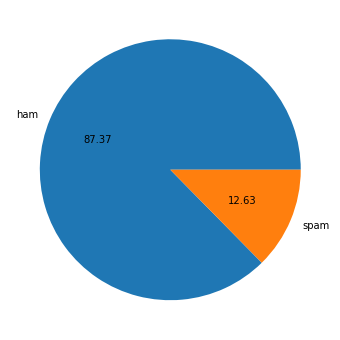

In [17]:
plt.figure(figsize=(10,6))
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct = "%0.2f")
plt.show()

**Clearly seen that data is imbalanced you should take care when making a model**

In [18]:
#find the number of character in particular text
df['num_characters'] = df['text'].apply(len)

In [19]:
df.head(2)

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29


In [20]:
#Number of word in particular text
df['num_words'] = df['text'].apply(lambda x : len(nltk.word_tokenize(x)))

In [21]:
df.head(2)

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8


In [22]:
# Number of sentences in any text 
df['num_sentences'] = df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))

In [23]:
df.head(2)

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2


In [24]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.923776,18.456375,1.962275
std,58.174846,13.323322,1.433892
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


It is not provide the clear picture for spam and ham , now divide the data into spam and ham then you easily know more about the data

In [25]:
## ham
df[df['target']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.456820,17.123339,1.815545
std,56.356802,13.491315,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.977029
std,30.014336,7.011513,1.493676
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


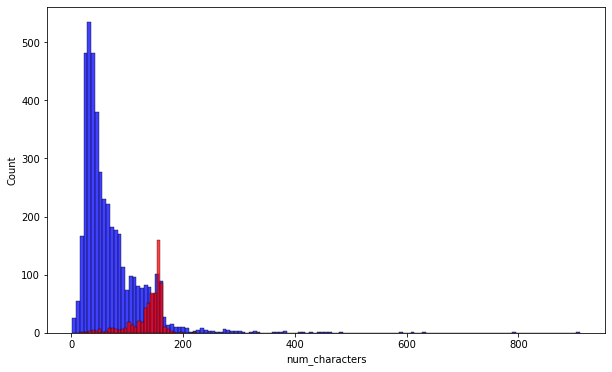

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['target']==0]['num_characters'],color='blue')
sns.histplot(df[df['target']==1]['num_characters'],color = 'red');

**It clear that ham sentences has longer length as compare to the spam sentences**

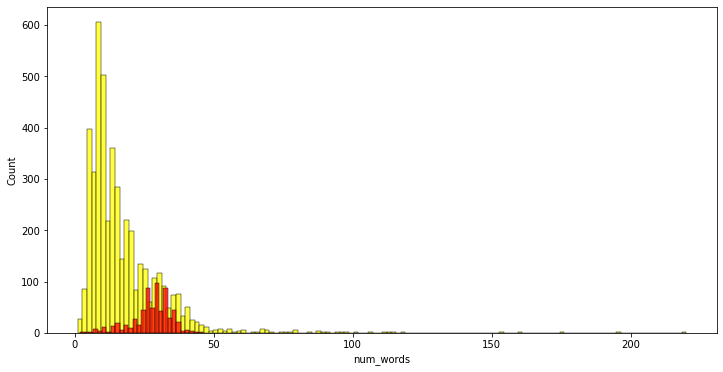

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'],color='yellow')
sns.histplot(df[df['target'] == 1]['num_words'],color='red');

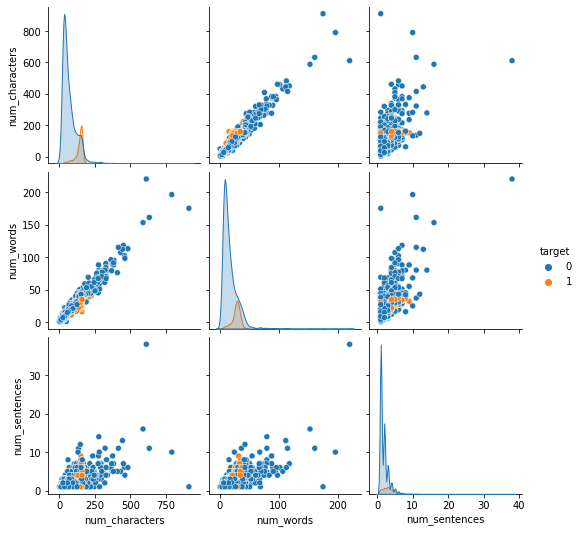

In [29]:
sns.pairplot(df,hue='target');

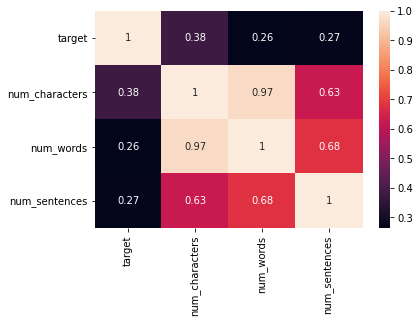

In [30]:
sns.heatmap(df.corr(),annot=True);

As their is high multicollinearity between the independent columns but we choice only one column which has high correlation with target variable which is 'num characters'

## Data Preprocessing

In [31]:
ps = PorterStemmer()

In [32]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    corpus = []
    for i in text:
        if i.isalnum():
            corpus.append(i)
    text = corpus[:]
    corpus.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            corpus.append(i)
    text = corpus[:]
    corpus.clear()
    for i in text:
        corpus.append(ps.stem(i))
    return " ".join(corpus)    

In [33]:
df['transformed_text'] = df['text'].apply(transform_text)

In [34]:
df.head(3)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...


In [35]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [36]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

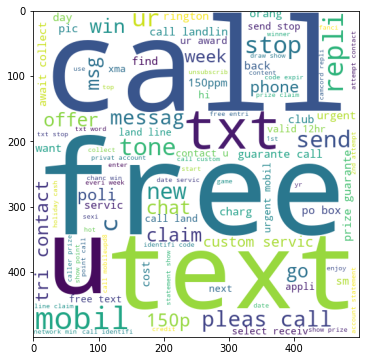

In [37]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc);

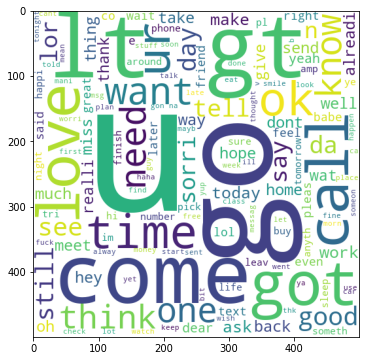

In [38]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [39]:
spam_corpus = []
for msg in df[df['target']==1]['transformed_text'].to_list():
    for word in msg.split():
        spam_corpus.append(word)

In [41]:
len(spam_corpus)

9941

In [48]:
pd.DataFrame(Counter(spam_corpus).most_common(5))[0]

0    call
1    free
2       2
3     txt
4    text
Name: 0, dtype: object

In [49]:
pd.DataFrame(Counter(spam_corpus).most_common(5))[1]

0    320
1    191
2    155
3    141
4    122
Name: 1, dtype: int64

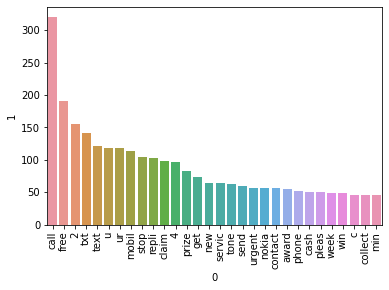

In [56]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show();

In [57]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
    

In [58]:
len(ham_corpus)

35303

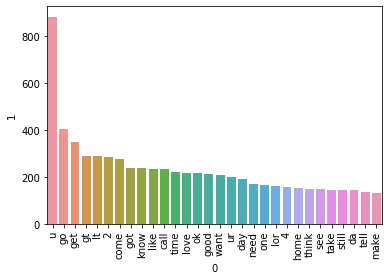

In [59]:
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show();

In [61]:
df.head(2)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni


## Model Building

In [66]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)


In [68]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [71]:
X.shape

(5169, 3000)

In [72]:
y = df['target'].values

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [79]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [80]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8704061895551257
[[788 108]
 [ 26 112]]
0.509090909090909


In [81]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.971953578336557
[[896   0]
 [ 29 109]]
1.0


In [82]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [84]:
#trying other algorithm
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [85]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [86]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision

In [87]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9748549323017408, 0.9745762711864406)

In [88]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.971953578336557
Precision -  1.0
For  DT
Accuracy -  0.9323017408123792
Precision -  0.8333333333333334
For  LR
Accuracy -  0.9564796905222437
Precision -  0.9696969696969697
For  RF
Accuracy -  0.9758220502901354
Precision -  0.9829059829059829
For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454
For  BgC
Accuracy -  0.9593810444874274
Precision -  0.8692307692307693
For  ETC
Accuracy -  0.9796905222437138
Precision -  0.975609756097561
For  GBDT
Accuracy -  0.9468085106382979
Precision -  0.9278350515463918
[00:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F

In [89]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [91]:
performance_df.head()

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.971954,1.000000
5,RF,0.975822,0.982906
8,ETC,0.979691,0.975610
0,SVC,0.974855,0.974576


In [92]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [93]:
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.971954
2,RF,Accuracy,0.975822
3,ETC,Accuracy,0.979691
4,SVC,Accuracy,0.974855
5,LR,Accuracy,0.956480
6,AdaBoost,Accuracy,0.961315
7,xgb,Accuracy,0.968085
8,GBDT,Accuracy,0.946809
9,BgC,Accuracy,0.959381


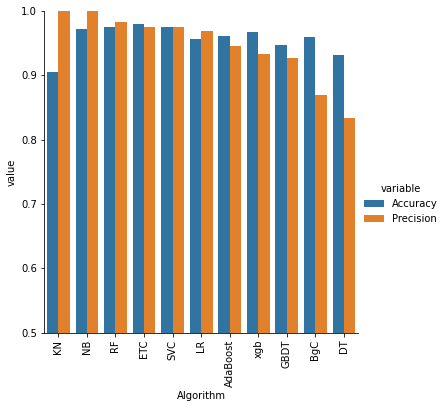

In [94]:
sns.catplot(x='Algorithm',y='value',hue='variable',data=performance_df1,kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [95]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [98]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [100]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9917355371900827


In [101]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [102]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [103]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9333333333333333


In [105]:
# Pickle the model and Vectorizer
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))